Script 5-1: Compute Spectral Clustering for Gaboon Viper Data

In [1]:
#create snake area network adjacency matrix
import numpy as np
import networkx as nx
np.random.seed(0)

adj_mat = [[1,1,1,0,0,0,1],
           [1,1,1,0,0,0,0],
           [1,1,1,0,0,0,0],
           [0,0,0,1,1,1,0],
           [0,0,0,1,1,1,0],
           [0,0,0,1,1,1,1],
           [1,0,0,0,0,1,1]]

adj_mat = np.array(adj_mat)

In [2]:
#create spatial weight matrix
weights_total = [[1,1,1,0,0,0,1],
           [1,1,1,0,0,0,0],
           [1,1,1,0,0,0,0],
           [0,0,0,1,1,1,1],
           [0,0,0,1,1,1,1],
           [0,0,0,1,1,1,1],
           [1,0,0,1,1,1,1]]

weights_total = np.array(weights_total)
adj_mat_w=np.multiply(adj_mat,weights_total)

In [3]:
#explore degree and Laplacian matrices
degree_matrix=np.diag(adj_mat_w.sum(axis=1))
laplacian_matrix=degree_matrix-adj_mat_w
print(degree_matrix)
print(laplacian_matrix)

[[4 0 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 4 0]
 [0 0 0 0 0 0 3]]
[[ 3 -1 -1  0  0  0 -1]
 [-1  2 -1  0  0  0  0]
 [-1 -1  2  0  0  0  0]
 [ 0  0  0  2 -1 -1  0]
 [ 0  0  0 -1  2 -1  0]
 [ 0  0  0 -1 -1  3 -1]
 [-1  0  0  0  0 -1  2]]


<class 'networkx.utils.decorators.argmap'> compilation 17:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


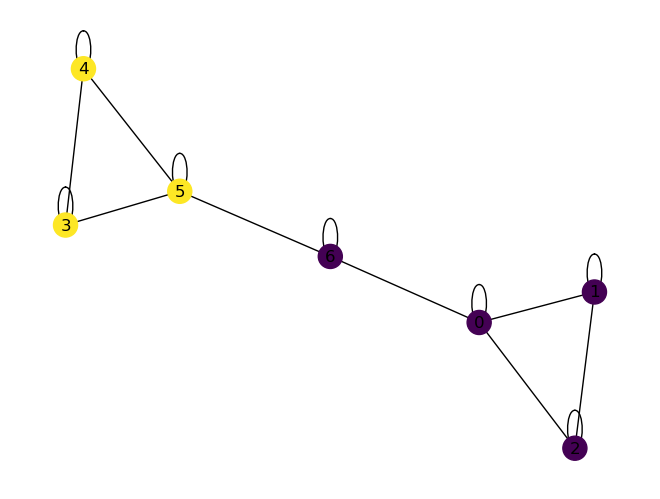

In [4]:
#define Fiedler vector and obtain clustering
G = nx.from_numpy_matrix(adj_mat_w)
ev = nx.linalg.algebraicconnectivity.fiedler_vector(G)
labels = [0 if v < 0 else 1 for v in ev]
labels

nx.draw(G,with_labels=True, node_color=labels)  

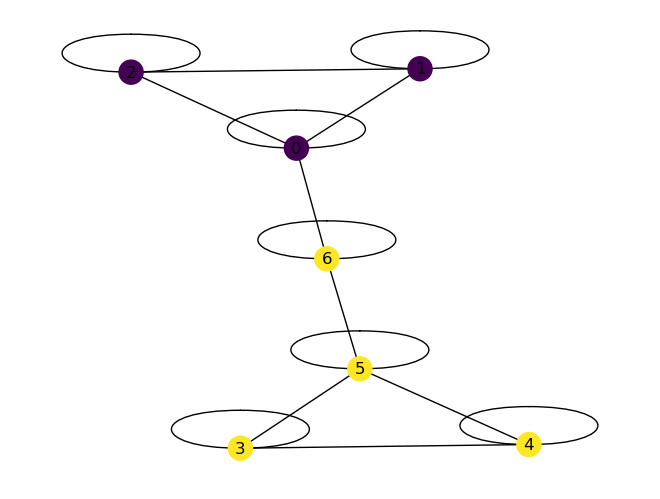

In [5]:
#perform spectral clustering with sklearn
from sklearn.cluster import SpectralClustering
from sklearn import metrics
sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sp_clust=sc.fit(adj_mat_w)
sc_labels=sp_clust.labels_
nx.draw(G,with_labels=True, node_color=sc_labels) 

Script 5-2: Spectral Clustering on Ecosystem Notes Data

In [6]:
#set up needed packages
import pandas as pd
import numpy as np
import os
#you may need to install sentence_transformers if the package is not already in your environment
#!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

In [7]:
#import first network dataset
File ="C:/users/njfar/OneDrive/Desktop/SC_Notes.csv"
pwd = os.getcwd()
os.chdir(os.path.dirname(File))
mydata = pd.read_csv(os.path.basename(File),encoding='latin1')

In [9]:
#prepare data
mydata['Notes']=mydata['Notes'].fillna(value=".")

#strip to text for input into BERT model
text_list=list(mydata.Notes)

In [10]:
#get BERT--768 vectors
#note, you'll need enough memory to load the transformer model
sbert_model1 = SentenceTransformer('all-mpnet-base-v2')

#encode data with BERT
encoded_text1=sbert_model1.encode(text_list)

In [11]:
#make nearest neighbors graph
from sklearn.neighbors import kneighbors_graph
n_adj = kneighbors_graph(encoded_text1, n_neighbors=3).toarray()

In [12]:
#run spectral clustering
from sklearn.cluster import SpectralClustering
from sklearn import metrics
sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sp_clust=sc.fit(n_adj)
sc_labels=sp_clust.labels_
print(sc_labels)

[0 0 1 0 0 0 1 1 0 1]


C:\Users\njfar\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [13]:
#examine notes
print(text_list)

['Mangrove ecosystem. Numerous butterflies, lizards, and insects. Gumbolimbo trees. Soggy soil.', 'Tropical pines. Scat shows raccoon and coyote populations here. Recent controlled burn.', 'Brown grass. Lots of children romping around. Damaged hibiscus plants.', 'Sewage and dumped barrels visible in lake. Dense mangroves. Fish population. Lizards.', 'Gumbolimbo trees, green grass, and pines. Chipmunks and squirrels sighted. Strong root systems.', 'Large duck population. Many banyan trees. Mostly green grass. Some gumbolimbo trees. Some iguanas.', 'Green grass. Few trees. Not many animals. Downed branches. Many children playing in protected areas.', 'Brown grass. A few crocodiles. Few trees. Downed branches. Some parking lot run-off.', 'Wide variety of tropical plants and trees. Large lizard and iguana population. Some parrots and turkey vultures.', 'Small grass area. Some saplings. Gravel paths. Many cars parked in non-parking zones. Lots of run-off.']


In [14]:
#create training dataset for supervised learning
#turn BERT embedding into array
BERT_array1=np.array([x for x in encoded_text1])

#convert to dataframes
BERT_df1=pd.DataFrame(BERT_array1)

In [15]:
#create KNN classifier and test accuracy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#get predictors and outcome
BERT_df1['Type']=mydata['Type']
df_train, df_test = train_test_split(BERT_df1, test_size=0.2, random_state=0)
X = df_train.iloc[:,0:767]
y = df_train.iloc[:,768]
X_test = df_test.iloc[:,0:767]
y_test = df_test.iloc[:,768]

#create KNN classifier and print accuracy
eu=KNeighborsClassifier(n_neighbors=2,metric='euclidean')
eu.fit(X,y)
print(eu.score(X_test,y_test))

1.0


C:\Users\njfar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
